# Bike hourly prediction analysis
### Royer Ticse Torres, July 2019


This notebook is a bike utilization analysis in python step-by-step. Starting from raw data to making a hourly prediction model on the [bike sharing](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) dataset.

![title](bike_pic.jpg "Header")

# Dive into data
First things first!. Understand the content of the data

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.externals import joblib
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data set
address = 'datasets/hour.csv'
df = pd.read_csv(address)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


No missing data in our dataset. Let's plot a histogram for each numerical attribute. 

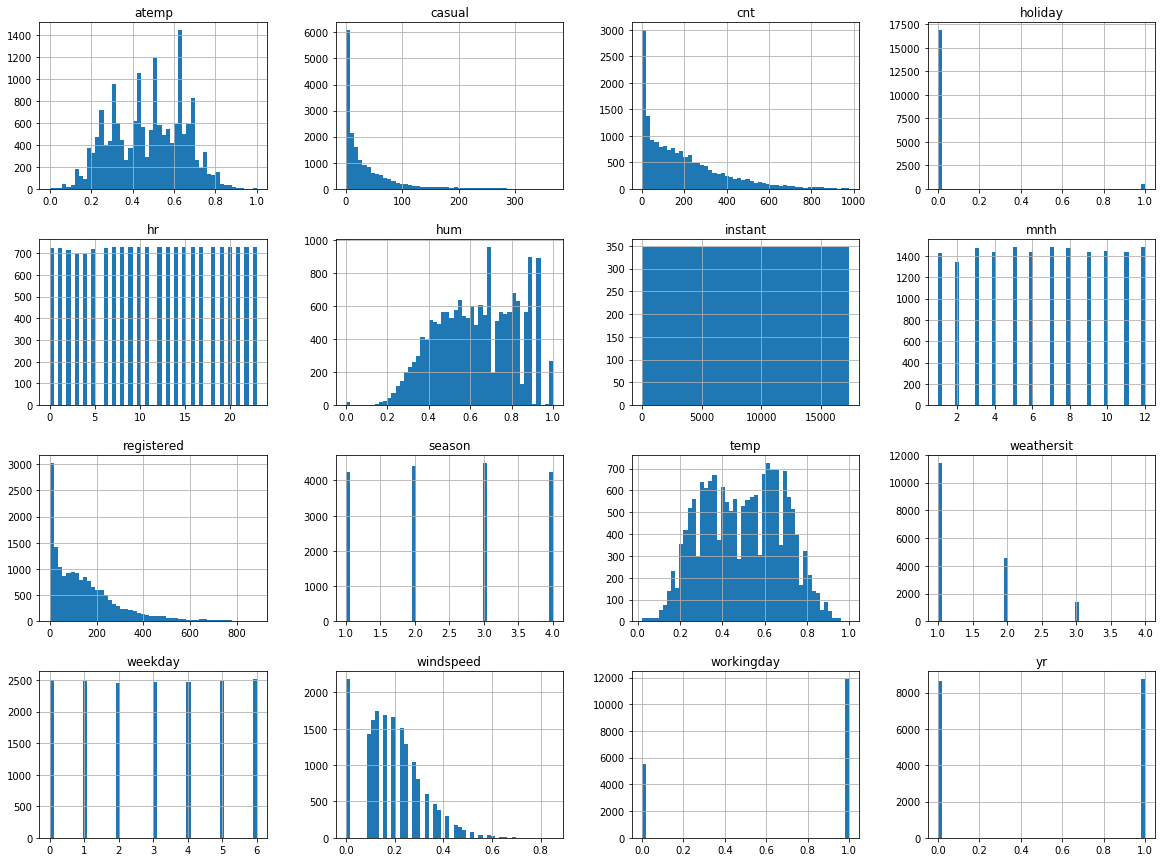

In [4]:
#plot a histogram for eachnumerical attribute. 
df.hist(bins=50, figsize=(20,15))
#fig = plt.gcf()
#fig.savefig("vars.png")
plt.show()


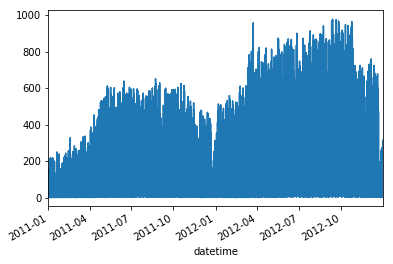

In [5]:
df_time = df.copy()
df_time['datetime'] = pd.to_datetime(df_time['dteday'], format="%Y-%m-%d")
#df['datetime_utc'] = pd.to_datetime(df['datetime'], utc='True')

df_time = df_time.set_index('datetime')

df_time["cnt"].plot()

In [6]:
address = 'datasets/day.csv'
data = pd.read_csv(address)
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


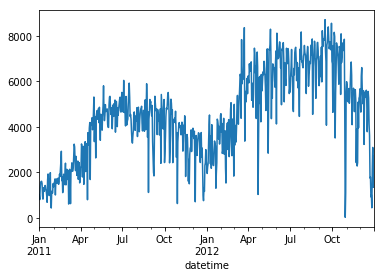

In [7]:
data['datetime'] = pd.to_datetime(data['dteday'], format="%Y-%m-%d")

data = data.set_index('datetime')

data["cnt"].plot()

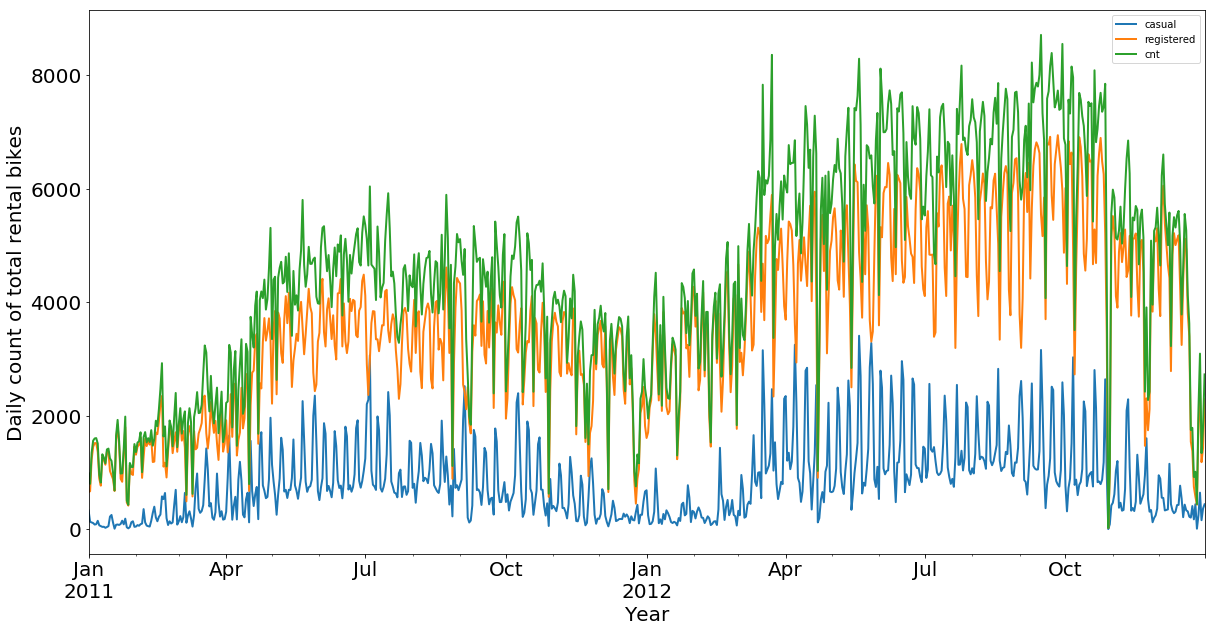

In [8]:
daily_count = data[['casual', 'registered', 'cnt']]

daily_count.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.ylabel('Daily count of total rental bikes', fontsize=20);
#plt.legend(bbox_to_anchor=(1.2, 0.5))
fig = plt.gcf()
#fig.savefig("year.png", bbox_inches='tight', pad_inches=0.0)


In [9]:
daily_count_2011 = daily_count.loc['2011-01-01':'2011-12-31']
daily_count_2012 = daily_count.loc['2012-01-01':'2012-12-31']
#df_2011_1000 = df_2011.sample(n=1000,random_state=25, axis=0)
#df_2012_1000 = df_2012.sample(n=1000,random_state=25, axis=0)


In [10]:
daily_count_2011.describe()

,casual,registered,cnt
count,365.000000,365.000000,365.000000
mean,677.402740,2728.358904,3405.761644
std,556.269121,1060.110413,1378.753666
min,9.000000,416.000000,431.000000
25%,222.000000,1730.000000,2132.000000
50%,614.000000,2915.000000,3740.000000
75%,871.000000,3632.000000,4586.000000
max,3065.000000,4614.000000,6043.000000


In [11]:
daily_count_2012.describe()

,casual,registered,cnt
count,366.000000,366.000000,366.000000
mean,1018.483607,4581.450820,5599.934426
std,758.989897,1424.331846,1788.667868
min,2.000000,20.000000,22.000000
25%,429.750000,3730.500000,4369.000000
50%,904.500000,4776.500000,5927.000000
75%,1262.000000,5663.000000,7011.250000
max,3410.000000,6946.000000,8714.000000


Let's do the correlation analysis. During this step we are cheking how features related to each other. 

In [12]:
corrMatt = df[["cnt","temp","atemp","hr","yr","season","mnth","windspeed","workingday","weekday","holiday","weathersit","hum"]].corr()


[Text(0, 0.5, 'cnt'),
 Text(0, 1.5, 'temp'),
 Text(0, 2.5, 'atemp'),
 Text(0, 3.5, 'hr'),
 Text(0, 4.5, 'yr'),
 Text(0, 5.5, 'season'),
 Text(0, 6.5, 'mnth'),
 Text(0, 7.5, 'windspeed'),
 Text(0, 8.5, 'workingday'),
 Text(0, 9.5, 'weekday'),
 Text(0, 10.5, 'holiday'),
 Text(0, 11.5, 'weathersit'),
 Text(0, 12.5, 'hum')]

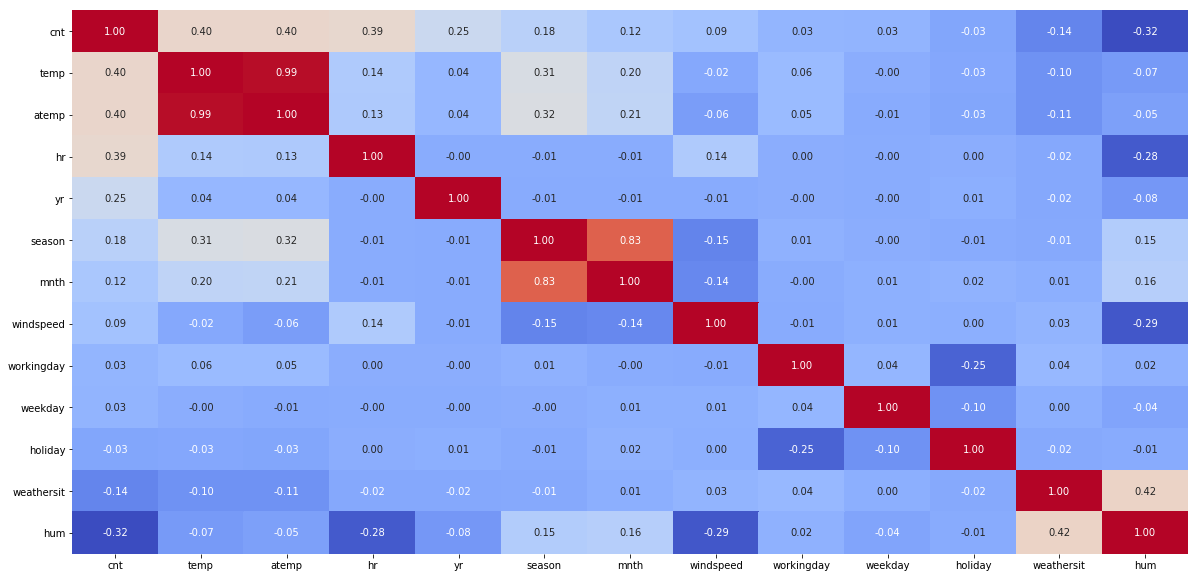

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sb.heatmap(corrMatt, annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
#plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)


In [14]:
corr_matrix = df.corr()
corr_matrix["cnt"].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

In [15]:
def adding_feature(df):
    df["dtemp"] = df['temp']-df['atemp']
    
    return df


In [16]:
df = adding_feature(df)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dtemp
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,-0.0479
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,-0.0527
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,-0.0527
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,-0.0479
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,-0.0479


In [17]:
corr_matrix = df.corr()
corr_matrix["cnt"].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
dtemp         0.256288
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

[Text(0, 0.5, 'instant'),
 Text(0, 1.5, 'season'),
 Text(0, 2.5, 'yr'),
 Text(0, 3.5, 'mnth'),
 Text(0, 4.5, 'hr'),
 Text(0, 5.5, 'holiday'),
 Text(0, 6.5, 'weekday'),
 Text(0, 7.5, 'workingday'),
 Text(0, 8.5, 'weathersit'),
 Text(0, 9.5, 'temp'),
 Text(0, 10.5, 'atemp'),
 Text(0, 11.5, 'hum'),
 Text(0, 12.5, 'windspeed'),
 Text(0, 13.5, 'casual'),
 Text(0, 14.5, 'registered'),
 Text(0, 15.5, 'cnt'),
 Text(0, 16.5, 'dtemp')]

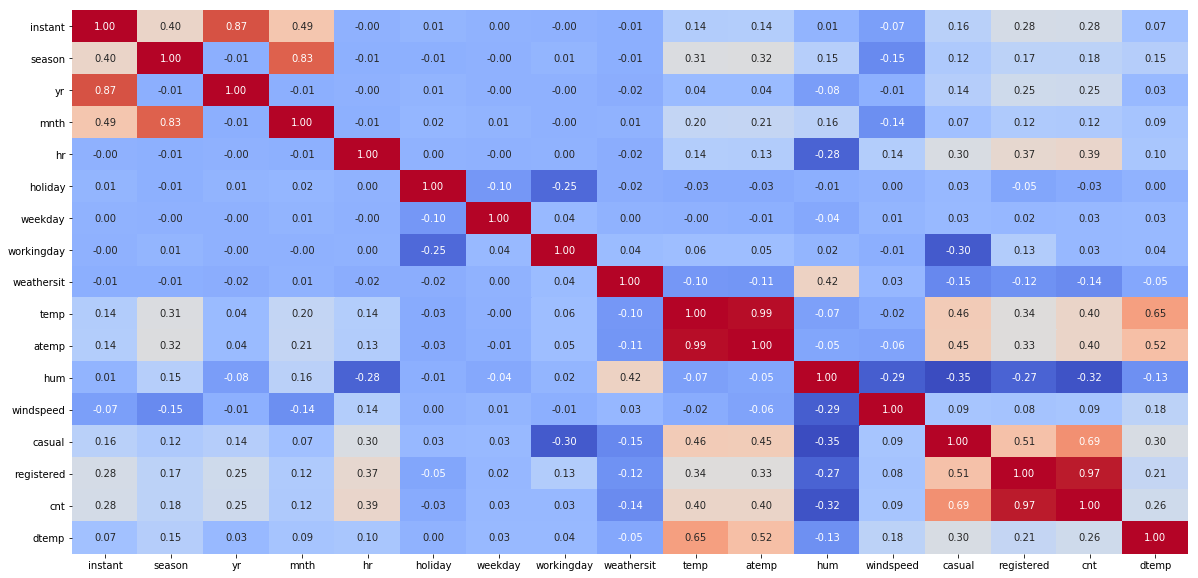

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sb.heatmap(corr_matrix, annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
#plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)

# Making predictive model

In [19]:
X = df.drop(['instant'], axis=1)
X = X.drop(['dteday'], axis=1)
X = X.drop(['yr'], axis=1)
X = X.drop(['registered'], axis=1)
X = X.drop(['casual'], axis=1)
X = X.drop(['cnt'], axis=1)
y =df['cnt'].values 

In [20]:
from sklearn.metrics import mean_squared_error
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [22]:
# Fit regression model
model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    loss='lad'
)

In [23]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
joblib.dump(model, 'trained_GBR_regresion_model.pkl')

['trained_GBR_regresion_model.pkl']

In [25]:
mse = mean_absolute_error(y_train, model.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % mse)

Training Set Mean Absolute Error: 42.6411


In [26]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [27]:
from sklearn.model_selection import cross_val_score

GBR_scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_mean_absolute_error',cv=5)
GBR_mae_scores = -GBR_scores
display_scores(GBR_mae_scores)

Scores: [47.36722948 46.61369522 46.28806493 47.25650845 45.47638535]
Mean: 46.60037668630211
Standard deviation: 0.6898760215675352


In [28]:
feature_labels = np.array(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
                           'temp','atemp', 'hum', 'windspeed', 'dtemp'])

In [29]:
# Load the trained model created with train_model.py
#model = joblib.load('trained_bike_BDT_regresion_model.pkl')

# Create a numpy array based on the model's feature importances
importance = model.feature_importances_

# Sort the feature labels based on the feature importance rankings from the model
feauture_indexes_by_importance = importance.argsort()

# Print each feature label, from most important to least important (reverse order)
for index in feauture_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))

holiday - 0.33%
windspeed - 1.51%
weathersit - 1.76%
mnth - 1.97%
season - 2.52%
weekday - 2.68%
dtemp - 2.75%
hum - 3.78%
atemp - 5.76%
workingday - 6.99%
temp - 9.23%
hr - 60.72%


# Make predictions

In [30]:
GBR_model = joblib.load('trained_GBR_regresion_model.pkl')

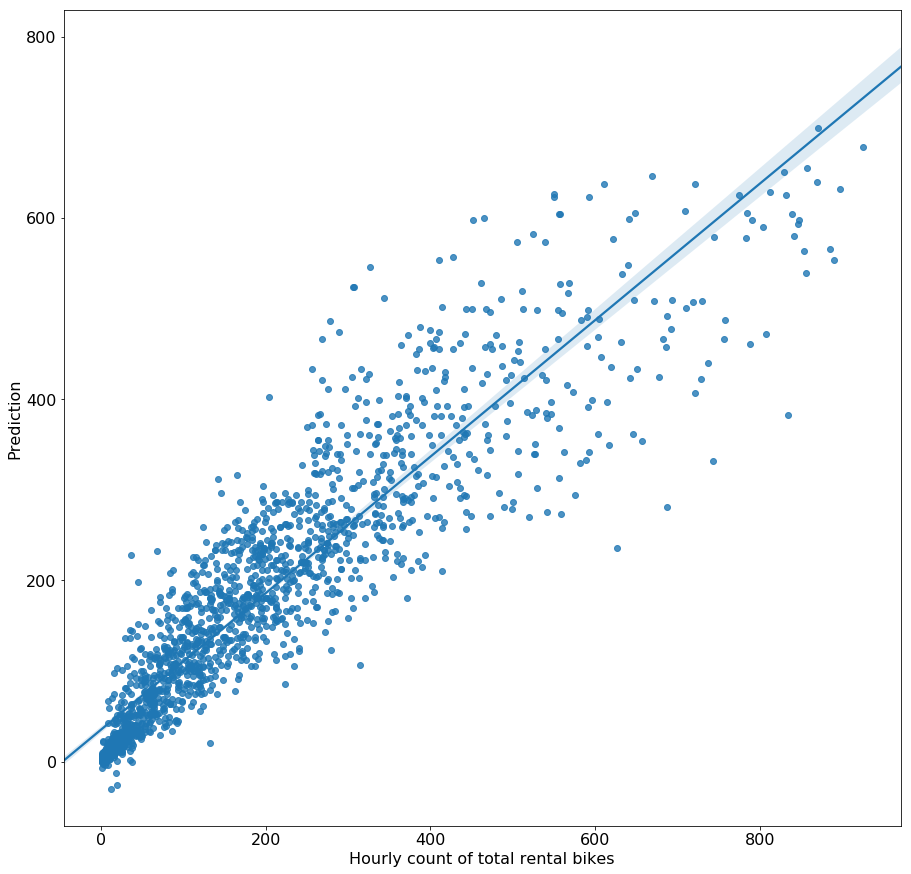

In [34]:
#y_test.loc[:, 'Prediction'] = np.round(model.predict(X_test))
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
b =sb.regplot(y_test, np.round(GBR_model.predict(X_test)), scatter=True)
#ax.set(xlabel='Hourly count of total rental bikes', ylabel='Prediction')
b.set_xlabel("Hourly count of total rental bikes",fontsize=16)
b.set_ylabel("Prediction",fontsize=16)
b.tick_params(labelsize=16)
#plt.savefig('predictions.png', bbox_inches='tight', pad_inches=0.0)


In [32]:
mse = mean_absolute_error(y_test, GBR_model.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % mse)

Test Set Mean Absolute Error: 46.9628
